In [28]:
import pandas as pd
import os
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from glob import glob
from torch.optim.lr_scheduler import StepLR

In [29]:
def load_csvs(csv_paths):
    
    data = []
    cycles = []
   
    for path in (csv_paths):
        assert os.path.exists(path)
        df = pd.read_csv(path)
#         if df.Cycle_Index.unique().shape[0] > 2000:
#             continue
        print(df.Cycle_Index.unique().shape[0])
        df = df[df['Step_Index'] == 10] # discharge
        df = df[df['Step_Time'] > 0] # remove outliers
        df = df[df['Step_Time'] < 5000] #remove outliers
        df = df[df["Cycle_Index"] > 0] # remove outliers
            
        df = df[df["Voltage"] <3.21] 
        df = df[df["Voltage"] >2.95]
        df["Charge_Capacity"] /= 1.1
            
        
        data.append(df)
        cycle = df["Cycle_Index"].unique()
        cycles.append(cycle)
        
        print (f"total points in {path}", df.shape)
    
    
    return data, cycles


In [30]:
def plot_cycles(data, cycles):
    print("plotting...")
    for d, cycle in zip(data, cycles):
        for i,c in enumerate(cycle):
            cycle_data = d[d.Cycle_Index == c]
            time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
            try:
                time = time - time[0]
            except:
                print (time, voltage, "skipping")
                continue
            plt.xlabel("time")
            plt.ylabel("voltage")
            plt.plot(time,voltage)

    plt.show()
    

In [31]:
def fit_spline(data, cycles, no_points=500):
    i = 0
    
    for cycle, d in zip (cycles, data):
        cell_np = []
        for index, c in enumerate (cycle):
            cycle_data = d[d["Cycle_Index"] == c]
            
            time, voltage, capacity, ind = cycle_data.Step_Time.values, cycle_data.Voltage, cycle_data.Charge_Capacity, cycle_data.Cycle_Index
            time = time - time[0]
            
            # using spline function to to make dimensions of all cycles equal (to create equal number of points in every cycle)
            ius = InterpolatedUnivariateSpline(time, voltage, k=1)

            # creating linear space 0, 200 of 20,000 points
            xi = np.linspace(0,700, 20000)
            yi_test = ius(xi)

            index_1 = np.argmin(np.abs(yi_test[:1000] - 3.2))
            index_2 = np.argmin(np.abs(yi_test - 3.0))

            indices = np.linspace(index_1, index_2, no_points).astype(int)

            #discarding points that are greater than time
#             xi = xi[xi < time[-1]]
            #creating indices equal to number of points of xi and selecting 400 equidistant integers
#             indices = np.linspace(0, time[-1]*100 -1, no_points).astype(int)
#             #selecting time at specified indices
            xi = xi[indices]
            yi = ius(xi)
            if yi[yi<2.998].any():
                continue
#                       
            ind = np.zeros_like(xi) + ind.values[0]
            capacity = np.zeros_like(xi) + np.max(capacity)
            cell_np.append(np.array([xi, yi, capacity, ind]))
        cell_np = np.concatenate(cell_np, axis=1)
        cell_np = np.transpose(cell_np, (1,0))
        data[i] = pd.DataFrame(cell_np, columns = ['Step_Time', 'Voltage', 'Charge_Capacity', 'Cycle_Index'])
        i+=1
        
    return data

In [39]:
def find_error(data, cycles):
    
    for d, cycle in zip(data, cycles):
        for i,c in enumerate(cycle):
            cycle_data = d[d.Cycle_Index == c]
            time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
            
            pts = len(time)
            
            for i in range(pts -1):
                if time[i + 1] - time[i] <= 0:
                    print (f"Error is in {c} cycle at time {time[i]}")
                    
            

In [40]:
mit_csvs = glob("./MIT_data/*csv*")
#glob("./Capacity_data/MIT/*")
for csv in mit_csvs:
    print (csv)


./MIT_data\2017-05-12_6C-40per_3_6C_CH34_b1c27_discharge.csv


840
total points in ./MIT_data\2017-05-12_6C-40per_3_6C_CH34_b1c27_discharge.csv (147570, 8)
plotting...


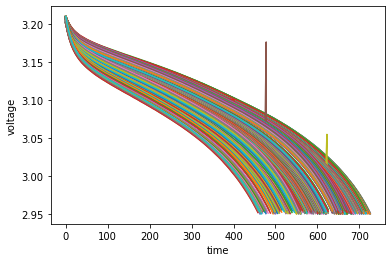

In [41]:
mit_data, mit_cycles = load_csvs(mit_csvs)
plot_cycles(mit_data, mit_cycles)

In [42]:
find_error(mit_data, mit_cycles)

Error is in 101 cycle at time 1950.56329999998


In [27]:
mit_d = fit_spline(mit_data.copy(), mit_cycles, no_points=500)

ValueError: x must be increasing if s > 0

In [ ]:
len(mit_d)